In [1]:
import time
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from IPython.display import HTML, display
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.patches import Patch
from tqdm import tqdm
import requests
from tqdm import tqdm
from xml.etree import ElementTree

display(HTML("<style>.container { width:100% !important; }</style>"))

# Generating the figure 2.
From the drug-gene co-occurence on attention coefficients, we search the paper on Pubmed.   
Then process it with DTI informaiton.   
The data is from [preprocess_for_fig2.ipynb](https://github.com/inoue0426/drGAT/blob/main/Figs/preprocess_for_fig2.ipynb)

In [2]:
df = pd.read_csv("val_PM.csv")
df

,NSC,drug,gene,num,rank
0,740,Methotrexate,TYMS,67,3
1,740,Methotrexate,ATIC,67,1
2,752,Thioguanine,BST2,0,5
3,752,Thioguanine,APBB1IP,0,1
4,752,Thioguanine,SLC43A3,2,3
...,...,...,...,...,...
4875,820919,4-methyl-3-(1-methyl-6-(pyridin-3-yl)-1H-pyraz...,LOC100128816,0,1
4876,820919,4-methyl-3-(1-methyl-6-(pyridin-3-yl)-1H-pyraz...,PSMB8,0,5
4877,820919,4-methyl-3-(1-methyl-6-(pyridin-3-yl)-1H-pyraz...,SPG20,0,3
4878,820919,4-methyl-3-(1-methyl-6-(pyridin-3-yl)-1H-pyraz...,LITAF,0,4


In [3]:
np.sum(df['num'] > 0)

356

In [4]:
dti = pd.read_csv('nci_dti.csv', index_col=0)[['NSC', 'Drug Name', 'Gene']]
dti.columns = ['NSC', 'drug', 'gene']
dti.NSC = dti.NSC.astype(int)
dti.head()

,NSC,drug,gene
1138,3061,Pyrimethamine,DHFR
1139,757306,Pyrimethamine,DHFR
1140,3061,Pyrimethamine,HEXB
1141,757306,Pyrimethamine,HEXB
1189,633781,Lovastatin,HMGCR


In [5]:
# NSCベースのキーのみを作成
df["key1"] = df["NSC"].astype(str) + "_" + df["gene"]
dti["key1"] = dti["NSC"].astype(str) + "_" + dti["gene"]

# key1 のみでセットを作成
key1_set = set(dti["key1"].dropna())

# NSCベースの dti_existed フラグを立てる
df["dti_existed"] = df["key1"].isin(key1_set).astype(int)

# 不要な一時列を削除
df = df.drop(columns=["key1"])

# predicted_positive フラグも再計算
df["predicted_positive"] = (df["num"] > 0).astype(int)

In [6]:
# lowercase統一
df["drug_gene"] = df["NSC"].astype(str) + "_" + df["gene"].str.upper()
dti["drug_gene"] = dti["NSC"].astype(str) + "_" + dti["gene"].str.upper()

# セット比較
predicted_keys = set(df["drug_gene"])
dti_keys = set(dti["drug_gene"])

# DTIにあるが予測に出なかったもの
missed_dti_completely = dti[~dti["drug_gene"].isin(predicted_keys)]

# 件数と例を表示
print("Completely missed known DTI:", len(missed_dti_completely))

Completely missed known DTI: 361


In [7]:
# Novel predictions
novel_predictions = df[df["dti_existed"] == 0]
novel_total = len(novel_predictions)
novel_supported = (novel_predictions["num"] > 0).sum()
novel_pubmed_precision = novel_supported / novel_total if novel_total > 0 else 0

# Known DTI support
known_dti_total = (df["dti_existed"] == 1).sum()
known_dti_supported = ((df["dti_existed"] == 1) & (df["num"] > 0)).sum()
known_dti_pubmed_recall = known_dti_supported / known_dti_total if known_dti_total > 0 else 0

df["pubmed_hit"] = (df["num"] > 0).astype(int)
novel_top5 = df[(df["dti_existed"] == 0) & (df["rank"] <= 5)]
per_novel_drug_hit = novel_top5.groupby("drug")["pubmed_hit"].any()
fraction_with_novel_hit = per_novel_drug_hit.mean()

known_top5 = df[(df["dti_existed"] == 1) & (df["rank"] <= 5)]
per_known_drug_hit = known_top5.groupby("drug")["pubmed_hit"].any()
fraction_with_known_hit = per_known_drug_hit.mean()

# Top-5 pubmed hit fraction per drug
df["top5"] = df["rank"] <= 5
df["pubmed_hit"] = df["num"] > 0
per_drug_hit = df[df["top5"]].groupby("drug")["pubmed_hit"].any()
fraction_with_hit = per_drug_hit.mean()

# Summary stats
summary_stats = {
    "Total Predictions": len(df),
    "Unique Drugs": df["drug"].nunique(),
    "Unique Genes": df["gene"].nunique(),
    "Unique NSC IDs": df["NSC"].nunique(),
    "Novel Predictions (not in DTI)": novel_total,
    "PubMed-supported Novel Predictions": novel_supported,
    "Known DTI in dataset": known_dti_total,
    "PubMed-supported Known DTI": known_dti_supported,
    "Known DTI PubMed Recall": round(known_dti_pubmed_recall, 4),
    "Completely Missed Known DTI": len(missed_dti_completely),
}

# Additional stats
total_papers = df['num'].sum()
total_pubmed_hits = (df["num"] > 0).sum()
fraction_supported = total_pubmed_hits / len(df)
fraction_novel_in_pubmed_hits = novel_supported / total_pubmed_hits if total_pubmed_hits > 0 else 0
mean_pubmed_count = df[df["num"] > 0]["num"].mean()
median_rank_supported_novel = novel_predictions[novel_predictions["num"] > 0]["rank"].median()

summary_stats.update({
    "Total Papers": total_papers,
    'Total PubMed Hits': total_pubmed_hits, 
    # "Total PubMed-supported Predictions": total_pubmed_hits,
    # "Fraction PubMed-supported (overall)": round(fraction_supported, 4),
    "Fraction of PubMed Hits that are Novel": round(fraction_novel_in_pubmed_hits, 4),
    # "Mean PubMed Count (if supported)": round(mean_pubmed_count, 2),
    # "Median Rank of Supported Novel": median_rank_supported_novel,
    "Fraction of Drugs with PubMed Hit in Top-5": round(fraction_with_hit, 4),
    "Fraction of Novel Drugs with PubMed Hit in Top-5": round(fraction_with_novel_hit, 4),
    "Fraction of Known Drugs with PubMed Hit in Top-5": round(fraction_with_known_hit, 4),
})

# # Top-k stats
# for k in [1, 3, 5]:
topk = df[df["rank"] <= 5]
topk_pubmed_supported = (topk["num"] > 0).sum()
pubmed_precision = topk_pubmed_supported / len(topk)
summary_stats.update({
    f"Top-{5} PubMed Precision": round(pubmed_precision, 4),
})

summary_stats

{'Total Predictions': 4880,
 'Unique Drugs': 932,
 'Unique Genes': 297,
 'Unique NSC IDs': 976,
 'Novel Predictions (not in DTI)': 4669,
 'PubMed-supported Novel Predictions': 182,
 'Known DTI in dataset': 211,
 'PubMed-supported Known DTI': 174,
 'Known DTI PubMed Recall': 0.8246,
 'Completely Missed Known DTI': 361,
 'Total Papers': 16831,
 'Total PubMed Hits': 356,
 'Fraction of PubMed Hits that are Novel': 0.5112,
 'Fraction of Drugs with PubMed Hit in Top-5': 0.1931,
 'Fraction of Novel Drugs with PubMed Hit in Top-5': 0.122,
 'Fraction of Known Drugs with PubMed Hit in Top-5': 0.8509,
 'Top-5 PubMed Precision': 0.073}

## 📊 Summary of drGAT Prediction Results

This summary highlights the predictive power and interpretability of the **drGAT** model, validated via PubMed literature evidence.

### 🧬 Dataset Overview

| Metric                       | Value | Description                                                   |
|-----------------------------|-------|---------------------------------------------------------------|
| Total Predictions           | 4,880 | All predicted drug–gene interactions (top-5 per drug).        |
| Unique Drugs                | 932   | Number of distinct drug names.                                |
| Unique NSC IDs              | 976   | Number of unique compound identifiers.                        |
| Unique Genes                | 297   | Number of gene targets.                                       |

---

### ✅ Known DTI Recovery

| Metric                            | Value  | Description                                                                 |
|----------------------------------|--------|-----------------------------------------------------------------------------|
| Known DTIs in Prediction         | 211    | Pairs found in the reference DTI database.                                 |
| PubMed-supported Known DTIs      | 174    | Known DTIs with at least one supporting PubMed article.                    |
| **Known DTI PubMed Recall**      | 0.825  | Fraction of known DTIs recovered with literature support.                  |
| Completely Missed Known DTIs     | 361    | Known DTIs not recovered in top-5 predictions.                             |
| Fraction of Known Drugs w/ Hits  | 0.851  | Known drugs with ≥1 PubMed-supported prediction in top-5.                  |

---

### 🌱 Novel Prediction Validation

| Metric                                 | Value  | Description                                                                 |
|----------------------------------------|--------|-----------------------------------------------------------------------------|
| Novel Predictions (Not in DTI)         | 4,669  | Model predictions not included in the known DTI database.                  |
| PubMed-supported Novel Predictions     | 182    | Novel predictions backed by at least one PubMed article.                   |
| **Fraction of PubMed Hits that are Novel** | 0.511 | Over half of literature-supported predictions are novel.                   |
| Fraction of Novel Drugs w/ Hits        | 0.122  | Novel drugs with at least one PubMed-supported gene in top-5.              |

---

### 📚 PubMed Evidence

| Metric                      | Value   | Description                                                        |
|----------------------------|---------|--------------------------------------------------------------------|
| Total Papers Queried       | 16,831  | Number of articles retrieved across all predictions.              |
| Total PubMed Hits          | 356     | Predicted drug–gene pairs supported by at least one article.      |
| **Top-5 PubMed Precision** | 0.073   | Proportion of top-5 predictions supported by literature.          |
| Fraction of Drugs w/ Hits  | 0.193   | All drugs with ≥1 PubMed-supported gene in top-5 predictions.     |

---

### 📝 Key Takeaways

- ✅ **High recall for known DTIs**: 82.5% of known drug–target interactions (DTIs) are backed by PubMed.
- 🌱 **Strong novelty**: Over **50%** of PubMed-supported predictions are **novel**, not in the DTI database.
- 🔍 **Interpretability via attention**: Almost 20% of drugs have top-5 predictions supported by PubMed, highlighting useful attention-based ranking.
- ⚠️ **Room for precision improvement**: The overall **top-5 PubMed precision is 7.3%**, suggesting that additional filtering or re-ranking strategies may be beneficial.


In [8]:
tmp = pd.read_csv('nsc_cid_smiles_class_name.csv', usecols=['NSC', 'MECHANISM'])
tmp = tmp[tmp['MECHANISM'] == 'DNA']

In [9]:
import time
from Bio import Entrez
import requests

Entrez.email = "your_email@example.com"  # 自分のメールを入力

def get_pubmed_hit_count(drug, gene, max_retries=5, delay=1.0):
    query = f"{drug} AND {gene}"
    for attempt in range(max_retries):
        try:
            handle = Entrez.esearch(db="pubmed", term=query, retmax=0)
            record = Entrez.read(handle)
            handle.close()
            return int(record["Count"])
        except requests.exceptions.HTTPError as e:
            if e.response.status_code == 429:
                time.sleep(delay * (attempt + 1))  # エクスポネンシャルバックオフ
            else:
                return -1
        except Exception:
            return -1
    return -1  # リトライしても失敗

In [10]:
df['key'] = df['NSC'].astype(str) + '_' + df['gene']

In [11]:
# 1. MOA を NSC 単位で結びつける
moa_map = pd.read_csv('nsc_cid_smiles_class_name.csv', usecols=['NSC', 'MECHANISM']).dropna()
moa_map['NSC'] = moa_map['NSC'].astype(int)
df['NSC'] = df['NSC'].astype(int)

# 2. df に MOA をマージ
df_moa = df.merge(moa_map, on='NSC', how='left')

# 3. MOAごとに集計
summary = df_moa[df_moa['rank'] <= 5].groupby('MECHANISM').agg(
    total_predictions=('key', 'nunique'),
    pubmed_hits=('num', lambda x: (x > 0).sum())
)

# 4. 精度（PubMed-supported / 全予測）
summary['precision'] = summary['pubmed_hits'] / summary['total_predictions']
summary = pd.concat([
    summary[summary.index != 'Other'],
    summary[summary.index == 'Other']
])
summary_formatted = summary.copy()
summary_formatted["precision"] = (summary_formatted["precision"] * 100).map("{:.2f}%".format)
summary_formatted.index = list(summary_formatted.index)
summary_formatted

,total_predictions,pubmed_hits,precision
Acetalax,15,0,0.00%
Apoptosis,175,10,5.71%
BRD,55,4,7.27%
DNA,1315,109,8.29%
HDAC,225,11,4.89%
HSP90,70,4,5.71%
Ho,65,12,18.46%
Kinase,2350,151,6.43%
Methylation,65,5,7.69%
PSM,60,7,11.67%


100%|███████████████████████████████████████████████████████████████████| 24/24 [00:12<00:00,  1.90it/s]


<Figure size 9000x4500 with 0 Axes>

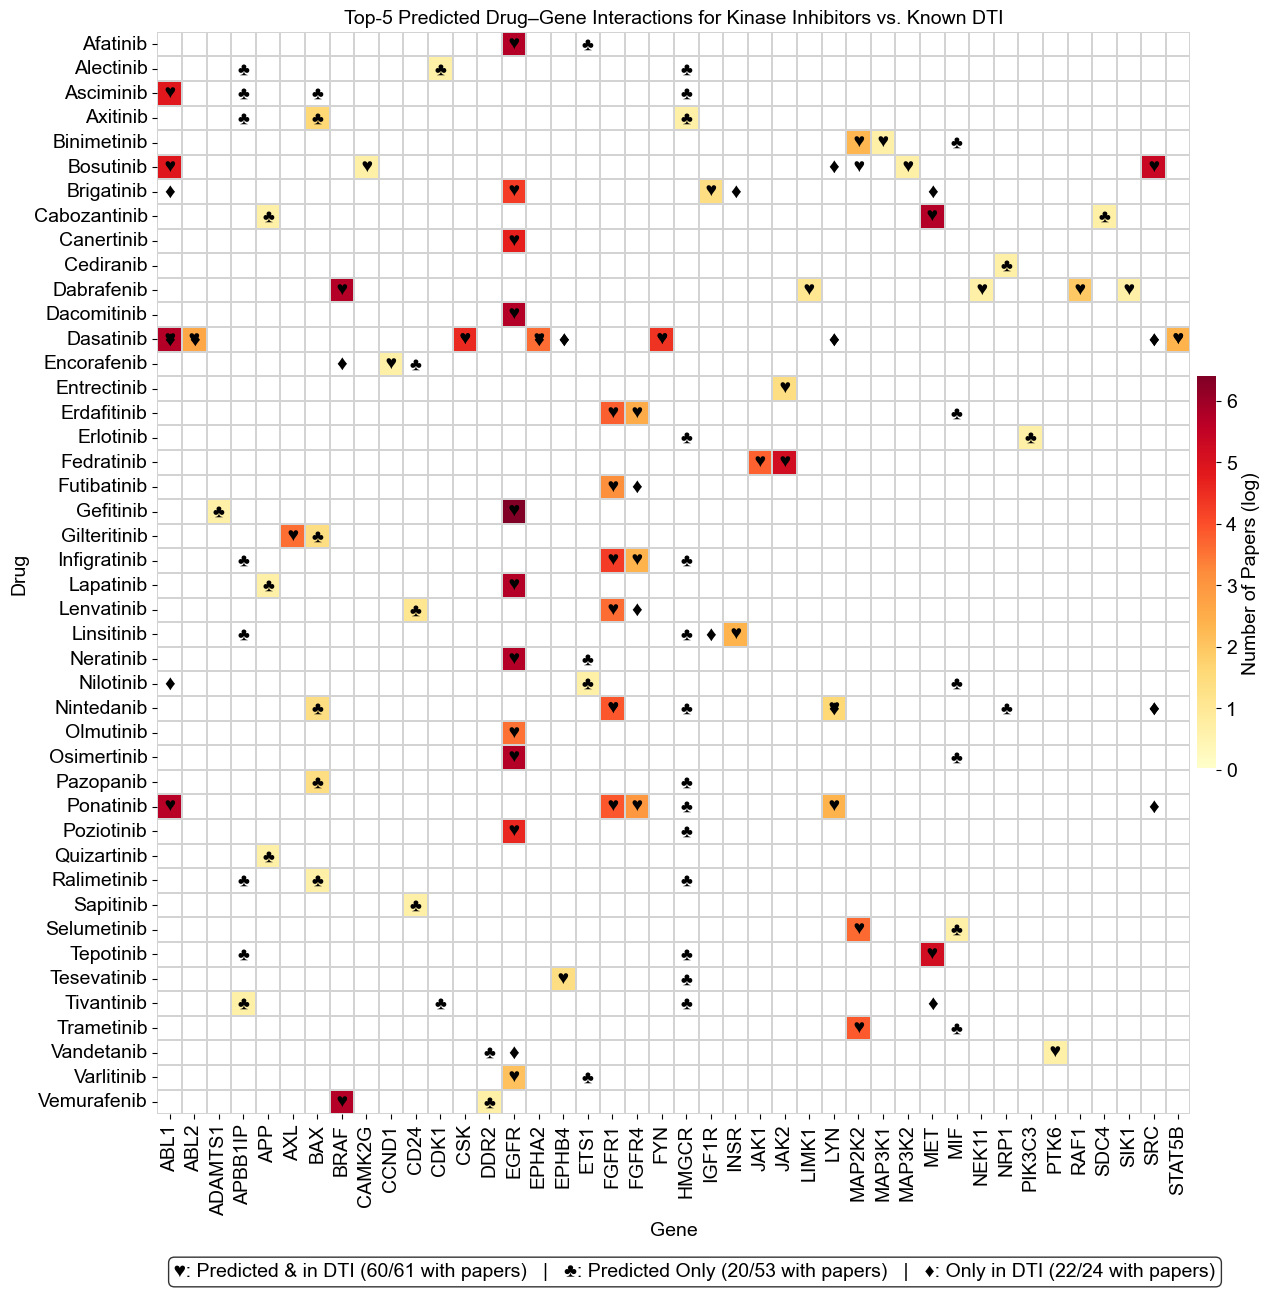

In [13]:
# Creating Heatmap without annotations (numbers)
plt.figure(figsize=(30, 15), dpi=300)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

font_size = 14

# --- データ読み込みと前処理 ---
df = df_moa[df_moa['MECHANISM'] == 'Kinase']
df = df[df['drug'].str.lower().str.contains('nib')]
df.drug = df.drug.replace('Erlotinib hydrochloride', 'Erlotinib')

dti = pd.read_csv('nci_dti.csv', index_col=0)[['NSC', 'Drug Name', 'Gene']]
dti.columns = ['NSC', 'drug', 'gene']
dti['NSC'] = dti['NSC'].astype(int)

dti['key'] = dti['NSC'].astype(str) + '_' + dti['gene']
df['dti_existed'] = df['key'].isin(set(dti['key'])).astype(int)

# --- Pivot for Heatmap ---
pivot = df.pivot_table(
    index='drug',
    columns='gene',
    values='num',
    aggfunc='sum'
)

pivot = pivot.loc[(pivot.sum(axis=1) > 0), (pivot.sum() > 0)]
log_pivot = np.log1p(pivot)

# --- Marker Categories (based on model prediction vs DTI existence) ---
predicted_df = df[df['rank'] <= 5]
predicted_keys = set(predicted_df['key'])
tp_keys = predicted_keys & set(dti['key'])
fp_keys = predicted_keys - set(dti['key'])
fn_keys = set(dti['key']) - predicted_keys

drug_to_nsc = df.drop_duplicates(['drug', 'NSC']).set_index('drug')['NSC'].to_dict()

from collections import defaultdict

drug_to_nscs = defaultdict(set)
for _, row in df[['drug', 'NSC']].drop_duplicates().iterrows():
    drug_to_nscs[row['drug']].add(str(row['NSC']))

# pivot_keys 生成も対応させる:
pivot_keys = {
    f"{nsc}_{gene}"
    for drug in pivot.index
    for gene in pivot.columns
    for nsc in drug_to_nscs.get(drug, [])
}

# --- TP ---
tp = predicted_df[predicted_df['key'].isin(tp_keys & pivot_keys)].drop_duplicates('key')

# --- FP ---
fp = predicted_df[predicted_df['key'].isin(fp_keys & pivot_keys)].drop_duplicates('key')

# --- FN ---
fn_df = df[df['key'].isin(fn_keys & pivot_keys)].drop_duplicates('key')
fn_missing = dti[dti['key'].isin((fn_keys - set(df['key'])) & pivot_keys)].copy()

results = []
for drug, gene in tqdm(zip(fn_missing['drug'], fn_missing['gene']), total=len(fn_missing)):
    count = get_pubmed_hit_count(drug, gene)
    results.append(count)
    time.sleep(0.34)  # NCBI推奨：最大3回/秒まで

fn_missing['num'] = results

fn = pd.concat([fn_df, fn_missing], ignore_index=True).drop_duplicates('key')

# --- Plot ---
base_cmap = plt.get_cmap("YlOrRd", 256)
colors = base_cmap(np.linspace(0, 1, 256))
colors[0] = [1, 1, 1, 1]
new_cmap = ListedColormap(colors)

fig, ax = plt.subplots(figsize=(14, 20))
heatmap = sns.heatmap(
    log_pivot,
    cmap=new_cmap,
    ax=ax,
    square=True,
    linewidths=0.1,
    cbar_kws={
        'label': 'Number of Papers (log)',
        'shrink': 0.2,
        'pad': 0.005
    },
    linecolor='lightgray',
)

# --- アノテーション関数 ---
def annotate_markers(df_mark, marker, color, size=10):
    for _, row in df_mark.iterrows():
        try:
            y = pivot.index.get_loc(row['drug'])
            x = pivot.columns.get_loc(row['gene'])
            ax.text(
                x + 0.5,
                y + 0.5,
                marker,
                ha='center',
                va='center',
                color=color,
                fontsize=size
            )
        except KeyError:
            continue

# 呼び出し時だけサイズを変える
annotate_markers(tp, '♥', 'black', size=13)
annotate_markers(fp, '♣', 'black', size=13)
annotate_markers(fn, '♦', 'black', size=15)

# --- 各マーカータイプの PubMed サポート数 ---
tp_with_paper = (tp["num"] > 0).sum()
fp_with_paper = (fp["num"] > 0).sum()
fn_with_paper = (fn["num"] > 0).sum()

# カウント
tp_count = len(tp)
fp_count = len(fp)
fn_count = len(fn)

# --- 凡例テキストを横長に ---
legend_labels = [
    f"♥: Predicted & in DTI ({tp_with_paper}/{tp_count} with papers)",
    f"♣: Predicted Only ({fp_with_paper}/{fp_count} with papers)",
    f"♦: Only in DTI ({fn_with_paper}/{fn_count} with papers)"
]

# 横長に連結
legend_text = "   |   ".join(legend_labels)

# --- 凡例のスタイル ---
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

# --- 凡例を図の下に配置 ---
fig.text(
    0.5,         # 中央
    0.155,       # 下方向（調整可能）
    legend_text,
    ha='center',
    va='top',
    fontsize=font_size,
    bbox=props
)

# 軸ラベルと目盛りフォントサイズを調整
ax.set_xlabel("Gene", fontsize=font_size)
ax.set_ylabel("Drug", fontsize=font_size)
ax.set_title("Top-5 Predicted Drug–Gene Interactions for Kinase Inhibitors vs. Known DTI", fontsize=font_size)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=font_size, rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=font_size, rotation=0)

# カラーバーのフォントサイズも変更
cbar = heatmap.collections[0].colorbar
cbar.ax.yaxis.label.set_size(font_size)
cbar.ax.tick_params(labelsize=font_size)

plt.tight_layout()
plt.savefig("fig2.pdf", bbox_inches="tight")
plt.show()

In [69]:
df_moa.to_csv('moa_with_top5.csv')